In [1]:
import os
import time
import logging
import argparse
import numpy as np
from tqdm import tqdm
import scipy.io as sio
from copy import deepcopy
from einops import rearrange
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from torch.optim.adam import Adam
import torch.backends.cudnn as cudnn
from timm.models.vision_transformer import PatchEmbed, Block


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler


from data_prepare import mirror_hsi
from data_prepare import choose_all_pixels, all_data
from data_prepare import choose_pretrain, pretrain_data
from data_prepare import choose_train_and_test, train_and_test_data, train_and_test_label


from CNNUtils import train, test, valid
from Utils import plot_confusion_matrix, print_args
from Utils import output_metric, classification_map, list_to_colormap


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("RMAE")
parser.add_argument('--dataset', choices=['HU2013', 'HanChuan', 'Salinas', 'KSC'], default='Salinas', help='dataset to use')
parser.add_argument('--flag_test', choices=['test', 'train'], default='train', help='testing mark')
parser.add_argument('--gpu_id', default='0', help='GPU id')
parser.add_argument('--seed', type=int, default=42, help='number of the random seed')
parser.add_argument('--batch_size', type=int, default=128, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--train_number', type=int, default=10, help='num_train_per_class')
parser.add_argument('--pretrain_proportion', type=float, default=0.5, help='proportion_pretrain_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'HU2013':
    data = sio.loadmat(os.path.join(data_path, 'Houston.mat'))['Houston']
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'HanChuan':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
elif args.dataset == 'Salinas':
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
else:
    raise ValueError("Unknown dataset")
    
num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 16


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 15
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=217, band=15


## Dataloader Construction

In [7]:
total_pos_pretrain, y_pretrain = choose_pretrain(label, pretrain_proportion=args.pretrain_proportion, seed=args.seed)

mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

x_pretrain = pretrain_data(mirror_data, band, total_pos_pretrain, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [526, 231, 15]
*******************************************************
x_pretrain shape : (27064, 15, 15, 15), type = float64
*******************************************************


In [8]:
total_pos_pretrain[:10]

array([[204, 143],
       [127, 142],
       [421,  18],
       [265,  13],
       [ 63,  40],
       [471,  18],
       [106, 135],
       [ 12, 131],
       [114, 125],
       [ 94,  61]])

In [9]:
# load data
x_pretrain = torch.from_numpy(x_pretrain.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (40908, 15, 15, 15)
y_pretrain = torch.from_numpy(y_pretrain).type(torch.LongTensor)  # (40908,)
print(x_pretrain.shape)
print(y_pretrain.shape)

pretrain_label = Data.TensorDataset(x_pretrain, y_pretrain)
pretrain_loader = Data.DataLoader(pretrain_label, batch_size=args.batch_size, shuffle=True)

torch.Size([27064, 15, 15, 15])
torch.Size([27064])


## Model

In [10]:
def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M, )
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2, )  32

    pos = pos.reshape(-1)  # (M, )  169
    out = np.einsum('m, d -> md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1)  # (H*W, D)
    return emb


def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)  # (H*W, D)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)  # (1+H*W, D)
    return pos_embed

In [11]:
class IT(nn.Module):
    "Multihead Attention Block"
    def __init__(self, dim_Q, dim_K, dim_hidden=64, num_heads=4):
        super(IT, self).__init__()  # Induced Transformer
        self.dim_hidden = dim_hidden
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_hidden)
        self.fc_k = nn.Linear(dim_K, dim_hidden)
        self.fc_v = nn.Linear(dim_K, dim_hidden)
        self.fc_o = nn.Linear(dim_hidden, dim_Q)
        self.ln0 = nn.LayerNorm(dim_Q)
        self.ln1 = nn.LayerNorm(dim_K)
        self.ln2 = nn.LayerNorm(dim_Q)
        self.mlp = nn.Sequential(nn.Linear(dim_Q, 4*dim_Q), nn.GELU(), nn.Linear(4*dim_Q, dim_Q))

    def forward(self, Q, K):
        # LayerNorm
        Q_ = self.ln0(Q)
        # Attention
        Q_, K_, V_ = self.fc_q(Q_), self.fc_k(K), self.fc_v(K)
        dim_head = self.dim_hidden // self.num_heads  # 64 // 4 = 16
        Q_ = torch.cat(Q_.split(dim_head, 2), 0)  # (4*B, K, 16) 
        K_ = torch.cat(K_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        V_ = torch.cat(V_.split(dim_head, 2), 0)  # (4*B, M, 16) 
        A = torch.softmax(Q_.bmm(K_.transpose(1, 2)) / dim_head ** 0.5, 2)  # (4*B, K, M) 
        O = torch.cat(A.bmm(V_).split(Q.size(0), 0), 2)  # (B, K, 64)
        O = self.fc_o(O)
        # Residual
        O = Q + O
        # LayerNorm
        O_ = self.ln2(O)
        # Residual
        O = O + self.mlp(O_)
        return O

In [12]:
class RMAE(nn.Module):
    def __init__(self, img_size=15, patch_size=3, in_chans=15, embed_dim=128, depth=12, num_heads=8, decoder_embed_dim=64, decoder_depth=8, 
                 decoder_num_heads=8, reg_patch_size=5, reg_embed_dim=128):
        super(RMAE, self).__init__()
        self.in_chans = in_chans
        self.patch_size = patch_size
        self.reg_patch_size = reg_patch_size
        # --------------------------------------------------------------------------
        # RMAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) 
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  
        self.blocks = nn.ModuleList([Block(embed_dim, num_heads, qkv_bias=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim)
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # RMAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False) 
        self.decoder_blocks = nn.ModuleList([Block(decoder_embed_dim, decoder_num_heads, qkv_bias=True) for _ in range(decoder_depth)])
        self.decoder_norm = nn.LayerNorm(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)
        # --------------------------------------------------------------------------
        
        # --------------------------------------------------------------------------
        # RMAE regularizer specifics
        self.reg_num_patches = ((img_size - reg_patch_size) // reg_patch_size + 1)  ** 2
        self.reg_pos_embed = nn.Parameter(torch.zeros(1, self.reg_num_patches, reg_embed_dim), requires_grad=False)
        self.induce_token = nn.Parameter(torch.zeros(1, 1, reg_embed_dim))
        self.induce_embed = IT(reg_embed_dim, embed_dim)
        self.reg_norm = nn.LayerNorm(reg_embed_dim)
        self.reg_pred = nn.Linear(reg_embed_dim, reg_patch_size**2 * in_chans, bias=True)
        # --------------------------------------------------------------------------
        self.initialize_weights()

    def initialize_weights(self):
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)  
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0)) 

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))  

        reg_pos_embed = get_2d_sincos_pos_embed(self.reg_pos_embed.shape[-1], int(self.reg_num_patches**.5), cls_token=False)
        self.reg_pos_embed.data.copy_(torch.from_numpy(reg_pos_embed).float().unsqueeze(0))
        
        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))  # (embed_dim, in_chans, patch_size, patch_size) 
        
        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        nn.init.normal_(self.cls_token, std=.02)
        nn.init.normal_(self.mask_token, std=.02)
        nn.init.normal_(self.induce_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def random_masking(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]  (N, L)
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # 从小到大排序，返回索引 (N, L)
        ids_restore = torch.argsort(ids_shuffle, dim=1)  # 返回ids_shuffle中，原序列0,1,2,...的索引
        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)  # 原始序列编码所对应的掩模 (N, L)
        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x) 
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  
        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :] 
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  
        x = torch.cat([cls_tokens, x], dim=1) 
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)  # (B, 50, 128)
        return x, mask, ids_restore

    def forward_reg(self, x):
        induce_tokens = self.induce_token.repeat(x.shape[0], self.reg_num_patches, 1)  # (B, 49, 128)
        induce_tokens = induce_tokens + self.reg_pos_embed  # (B, 49, 128)
        x = self.induce_embed(induce_tokens, x)  # (B, 49, 128)
        x = self.reg_norm(x)
        x = self.reg_pred(x)  # (B, 49, 16)
        return x
        
    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)  
        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token (N, L+1, 32)
        # add pos embed
        x = x + self.decoder_pos_embed
        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        # predictor projection
        x = self.decoder_pred(x)  # (N, L+1, 4*4*3)
        # remove cls token
        x = x[:, 1:, :]
        return x  # (N, L, 4*4*3)

    def patchify(self, imgs, p):
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        h = w = imgs.shape[2] // p  # 8
        x = imgs.reshape(shape=(imgs.shape[0], self.in_chans, h, p, w, p))
        x = torch.einsum('nchpwq -> nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * self.in_chans))
        return x

    def unpatchify(self, x, p):
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        x = x.reshape(shape=(x.shape[0], h, w, p, p, self.in_chans))
        x = torch.einsum('nhwpqc -> nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], self.in_chans, h * p, h * p))
        return imgs

    def forward_loss(self, imgs, pred, mask, reg_pred):
        target = self.patchify(imgs, self.patch_size)  # (N, L, patch_size**2*1)
        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # (N, L), mean loss per patch
        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        reg_target = self.patchify(imgs, self.reg_patch_size)  # (N, L, reg_patch_size**2*1)
        reg_loss = (reg_pred - reg_target) ** 2
        reg_loss = reg_loss.mean()
        return loss + reg_loss
    
    def forward(self, imgs, mask_ratio=0.75):
        # latent: (N, 16, D), maks: (N, L), ids_restore: (N, L) 
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        # pred: (N, L, 4*4*3)
        pred = self.forward_decoder(latent, ids_restore)  # (N, L, p**2*1)
        reg_pred = self.forward_reg(latent)  # (N, 49, 16)
        recons = self.unpatchify(pred, self.patch_size)
        reg_recons = self.unpatchify(reg_pred, self.reg_patch_size)
        loss = self.forward_loss(imgs, pred, mask, reg_pred)
        return loss, recons, mask, reg_recons

In [13]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)


class AverageMeter(object):
    def __init__(self):
        self.reset()
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.cnt = 0
    def update(self, val, n=1):
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt


def pretrain(model, train_loader, device):
    model.train()

    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    
    train_len = len(train_loader)
    path = './model/rmae.pt'
    tic = time.time()
    for epoch in range(400):
        objs = AverageMeter()
        for batch_idx, (image, label) in tqdm(enumerate(train_loader)):
            image = image.to(device)
            optimizer.zero_grad()
            
            return_tuple = model(image)
            loss = return_tuple[0]
            
            loss.backward()
            optimizer.step()

            n = image.shape[0]
            objs.update(loss.data, n)  # 计算所有训练样本的平均损失
            if (batch_idx + 1) == len(train_loader):
                print('epoch: {}, loss: {:.4f}'.format(epoch+1, objs.avg))

        scheduler.step()
    toc = time.time()
    print("Running Time: {:.2f}".format(toc-tic))
    torch.save(model.state_dict(), path)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

rmae = RMAE()
rmae = rmae.to(device)

In [15]:
model_summary(rmae)

cls_token: 1x1x128 = 128
mask_token: 1x1x64 = 64
induce_token: 1x1x128 = 128
patch_embed.proj.weight: 128x15x3x3 = 17280
patch_embed.proj.bias: 128
blocks.0.norm1.weight: 128
blocks.0.norm1.bias: 128
blocks.0.attn.qkv.weight: 384x128 = 49152
blocks.0.attn.qkv.bias: 384
blocks.0.attn.proj.weight: 128x128 = 16384
blocks.0.attn.proj.bias: 128
blocks.0.norm2.weight: 128
blocks.0.norm2.bias: 128
blocks.0.mlp.fc1.weight: 512x128 = 65536
blocks.0.mlp.fc1.bias: 512
blocks.0.mlp.fc2.weight: 128x512 = 65536
blocks.0.mlp.fc2.bias: 128
blocks.1.norm1.weight: 128
blocks.1.norm1.bias: 128
blocks.1.attn.qkv.weight: 384x128 = 49152
blocks.1.attn.qkv.bias: 384
blocks.1.attn.proj.weight: 128x128 = 16384
blocks.1.attn.proj.bias: 128
blocks.1.norm2.weight: 128
blocks.1.norm2.bias: 128
blocks.1.mlp.fc1.weight: 512x128 = 65536
blocks.1.mlp.fc1.bias: 512
blocks.1.mlp.fc2.weight: 128x512 = 65536
blocks.1.mlp.fc2.bias: 128
blocks.2.norm1.weight: 128
blocks.2.norm1.bias: 128
blocks.2.attn.qkv.weight: 384x128 = 

In [ ]:
pretrain(rmae, pretrain_loader, device)

In [16]:
class Encoder(RMAE):
    def forward_encoder(self, x):
        # embed patches
        x = self.patch_embed(x)  # (B, 64, 64)
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]  # (B, 64, 64)
        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]  # (1, 1, 64)
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)  # (B, 1, 64)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, 64+1, 64)
        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)  # (B, 64+1, 64)
        latent = x[:, 0, :]
        return latent
         
    def forward(self, imgs):
        latent = self.forward_encoder(imgs)
        return latent

In [17]:
encoder = Encoder().cuda()

path = './model/rmae.pt'
encoder.load_state_dict(torch.load(path))
encoder.eval()
print('done')

done


In [18]:
def scatter(x, colors, num_classes=16):
    palette = np.array([[255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 0], [0, 255, 255], [255, 0, 255], [192, 192, 192], [128, 128, 128], 
                        [128, 0, 0], [128, 128, 0], [0, 128, 0], [128, 0, 128], [0, 128, 128], [0, 0, 128], [255, 165, 0], [255, 215, 0]])/255.
    
    # We create a scatter plot.
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int_)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(num_classes):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i+1), fontsize=24)
        txt.set_path_effects([PathEffects.Stroke(linewidth=5, foreground="w"), PathEffects.Normal()])
        txts.append(txt)
    fig.savefig('./tsne_rmae.pdf', bbox_inches='tight')

In [19]:
train_codings = []
train_tar = []
for batch_idx, (image, label) in enumerate(pretrain_loader):
    with torch.no_grad():
        image = image.to(device)
        label = label.to(device)
        codings = encoder(image)
    train_codings.append(codings.cpu().data)
    train_tar.append(label.cpu().data)

x_train = torch.concat(train_codings)
y_train = torch.concat(train_tar)

x_train_numpy = x_train.numpy()
y_train_numpy = y_train.numpy()

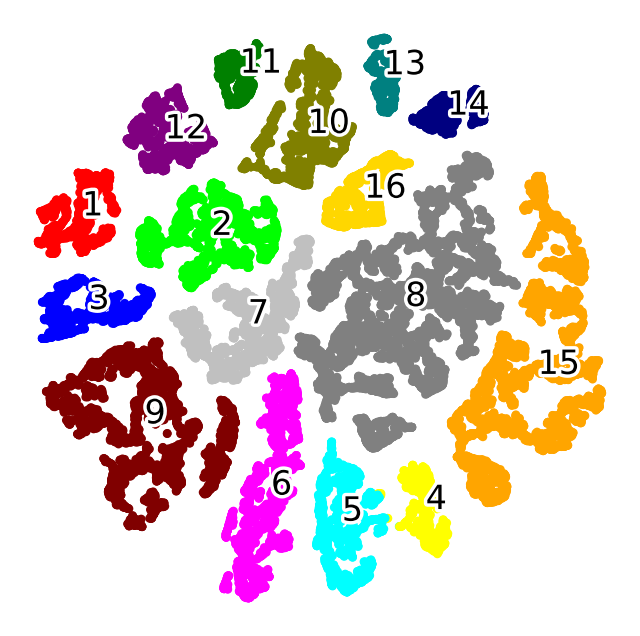

In [20]:
tsne_proj = TSNE(random_state=42).fit_transform(x_train_numpy)

scatter(tsne_proj, y_train_numpy, num_classes)

## Metrics

In [21]:
def mean_distance(codings, label, c=16):
    codings_per_class = []  # [(16, ) * 10]
    for i in range(c):
        codings_per_class.append(codings[label == i, :])
    centers = [torch.mean(codings_per_class[i], 0) for i in range(c)]
    
    inter_class_distance = torch.tensor(0.)
    for k in range(c - 1):
        for t in range(k + 1, c):
            inter_class_distance += torch.dist(centers[k], centers[t], p=2)
    mean_inter_class_distance = inter_class_distance / (c * (c - 1) / 2)
    
    intra_class_distance = torch.tensor(0.)
    for i in range(c):
        per_intra_class_distance = torch.tensor(0.)
        per_class_features = codings_per_class[i]
        center_feature = centers[i]
        num = per_class_features.size(0)
        for j in range(num):
            per_intra_class_distance += torch.dist(per_class_features[j], center_feature, p=2)
        per_intra_class_distance = per_intra_class_distance / num
        
        intra_class_distance += per_intra_class_distance
    mean_intra_class_distance = intra_class_distance / c
    return mean_intra_class_distance, mean_inter_class_distance

In [22]:
mean_intra_class_distance, mean_inter_class_distance = mean_distance(x_train, y_train, num_classes)

mean_intra_class_distance, mean_inter_class_distance

(tensor(4.1180), tensor(9.8321))

## Fine-tuning

In [23]:
encoder = Encoder()

path = './model/rmae.pt'
encoder.load_state_dict(torch.load(path))

<All keys matched successfully>

In [24]:
for param in encoder.parameters():
    param.requires_grad = False

for param in encoder.blocks[-1].parameters():
    param.requires_grad = True

In [25]:
cls_head = nn.Sequential(nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, num_classes))

In [26]:
classifier = nn.Sequential(encoder, cls_head)
classifier = classifier.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

In [27]:
model_summary(classifier)

0.blocks.11.norm1.weight: 128
0.blocks.11.norm1.bias: 128
0.blocks.11.attn.qkv.weight: 384x128 = 49152
0.blocks.11.attn.qkv.bias: 384
0.blocks.11.attn.proj.weight: 128x128 = 16384
0.blocks.11.attn.proj.bias: 128
0.blocks.11.norm2.weight: 128
0.blocks.11.norm2.bias: 128
0.blocks.11.mlp.fc1.weight: 512x128 = 65536
0.blocks.11.mlp.fc1.bias: 512
0.blocks.11.mlp.fc2.weight: 128x512 = 65536
0.blocks.11.mlp.fc2.bias: 128
1.0.weight: 64x128 = 8192
1.0.bias: 64
1.3.weight: 16x64 = 1024
1.3.bias: 16

Total Trainable Parameters: 207568


In [28]:
if args.dataset == 'HU2013':
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'HanChuan':
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'KSC':
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
elif args.dataset == 'Salinas':
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']

In [29]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (160, 15, 15, 15), type = float64
x_test  shape = (53969, 15, 15, 15), type = float64
x_valid  shape = (1600, 15, 15, 15), type = float64
*******************************************************
y_train: shape = (160,), type = int64
y_test: shape = (53969,), type = int64
y_valid: shape = (1600,), type = int64
*******************************************************


In [30]:
total_pos_train[:10]

array([[268,  24],
       [245,  47],
       [242,  56],
       [263,  38],
       [243,  49],
       [246,  49],
       [257,  21],
       [243,  45],
       [247,  36],
       [245,  51]])

In [31]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=32, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=32, shuffle=True)

torch.Size([160, 15, 15, 15])
torch.Size([53969, 15, 15, 15])
torch.Size([1600, 15, 15, 15])


In [32]:
acc_list = [0.00]
path = './model/finetune_rmae.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(classifier, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(classifier, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to finetune_rmae.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(classifier.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]
        
toc = time.time()
print("Training Time: {:.2f} seconds".format(toc-tic))
print("**************************************************")

Epoch: 001 - train_loss: 2.6540 - train_acc: 14.3750 - valid_loss: 2.4782 - valid_acc: 36.5000
val_acc improved from 0.0000 to 36.5000, saving model to finetune_rmae.pt
Epoch: 002 - train_loss: 2.3710 - train_acc: 42.5000 - valid_loss: 2.2272 - valid_acc: 64.1875
val_acc improved from 36.5000 to 64.1875, saving model to finetune_rmae.pt
Epoch: 003 - train_loss: 2.1168 - train_acc: 63.7500 - valid_loss: 1.9752 - valid_acc: 82.1875
val_acc improved from 64.1875 to 82.1875, saving model to finetune_rmae.pt
Epoch: 004 - train_loss: 1.8337 - train_acc: 83.1250 - valid_loss: 1.7144 - valid_acc: 89.5625
val_acc improved from 82.1875 to 89.5625, saving model to finetune_rmae.pt
Epoch: 005 - train_loss: 1.5770 - train_acc: 87.5000 - valid_loss: 1.4553 - valid_acc: 92.4375
val_acc improved from 89.5625 to 92.4375, saving model to finetune_rmae.pt
Epoch: 006 - train_loss: 1.3174 - train_acc: 93.7500 - valid_loss: 1.2073 - valid_acc: 94.8125
val_acc improved from 92.4375 to 94.8125, saving model t

## Testing

In [33]:
path = './model/finetune_rmae.pt'

classifier.load_state_dict(torch.load(path))
classifier.eval()
print('done')

done


In [34]:
tar_test, pre_test = test(classifier, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [35]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 95.03, AA: 97.87, Kappa: 0.9447
*******************************************************************
Recal: [ 99.35 100.   100.    99.93  95.5   99.97 100.    86.69  98.47  98.84
 100.    99.79 100.    99.91  87.46 100.  ]
*******************************************************************
Parameter:
dataset: Salinas
flag_test: train
gpu_id: 0
seed: 42
batch_size: 128
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
train_number: 10
pretrain_proportion: 0.5
*******************************************************************


In [36]:
average_accuracy = str(list(AA_test))
file_name = "./CR/rmae_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [37]:
def output_label(model, loader):
    model.eval()
    pre = np.array([]).astype('int')
    with torch.no_grad():
        for batch_idx, (batch_data, batch_target) in enumerate(loader):
            batch_data = batch_data.cuda()
            batch_pred = model(batch_data)  # (B, 9)
            _, pred = batch_pred.topk(1, axis=1)  # (B, 1)
            pp = pred.squeeze()
            pre = np.append(pre, pp.data.cpu().numpy())
    return pre

In [38]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=15)

*******************************************************
x_forward shape = (54129, 15, 15, 15), type = float64
x_backward  shape = (56975, 15, 15, 15), type = float64
*******************************************************


In [39]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([54129, 15, 15, 15])
torch.Size([56975, 15, 15, 15])


In [40]:
# output classification maps
pre_forward = output_label(classifier, forward_loader)
pre_backward = output_label(classifier, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

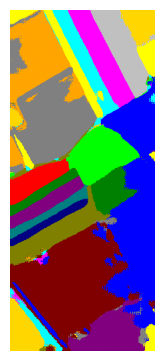

In [41]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './salinas_rmae.pdf')